## Optimizers

1. **Objective**: Research and investigate to compare the performance of `Adam
(Adaptive Moment Estimation)`, `RMSprop (Root Mean Square Prop)`, and
`AdamW (Adam with Weight Decay)` optimizers on a feedforward fully
connected neural network using the KMNIST dataset.
1. **Importance**: Understanding the strengths and weaknesses of different
optimization algorithms helps in selecting the right one for specific tasks in
deep learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import time
plt.style.use('dark_background')
dash_lines = "-"*80

!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 3.7 MB/s eta 0:00:00


## Notebook Guide
1. Github load latest files - `git clone`
1. Initialize `constants`
1. Grid/Randomized Search on Optimizer's params
1. Train - `NN` on Best `Optimizer params*`
1. Test - `NN` on Hold-out Testset
1. Save `model` & `results`

## Step 1. Github sync

In [ ]:
#Github clone
!git clone https://github.com/iamkevinxavier/humber-AdvDL-midterm.git

Cloning into 'humber-AdvDL-midterm'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 4), reused 7 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 284.79 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## Load Preprocessed Data
1. Standarized
1. train/val/test : 60/10/10

In [ ]:
#Load KMNIST preprocessed data from folder
file_path = 'humber-AdvDL-midterm/Dataset/kmnist_preprocessed.zip'
extract_to = './KMNIST_Dataset'
with zipfile.ZipFile(file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_to)

In [ ]:
train_file_path = os.path.join(extract_to, 'kmnist_train_preprocessed.npz')
val_file_path = os.path.join(extract_to, 'kmnist_val_preprocessed.npz')
test_file_path = os.path.join(extract_to, 'kmnist_test_preprocessed.npz')

## Step 2. Model Architecture

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Flatten()
    self.fc2 = nn.Linear(784, 128, dtype=torch.float64)
    self.fc3 = nn.ReLU()
    self.fc4 = nn.Linear(128, 64, dtype=torch.float64)
    self.fc5 = nn.ReLU()
    self.fc6 = nn.Linear(64, 10, dtype=torch.float64)
    self.fc7 = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    x = self.fc5(x)
    x = self.fc6(x)
    x = self.fc7(x)
    return x

model_nn = NeuralNet()

In [ ]:
#constant params*
learning_rate = 1e-3
batch_size = 64
num_epochs = 21
lossfunc = nn.CrossEntropyLoss()

#grid search params*
n_iter = 10
cv = 5

## Step 3. Grid Search for Optimizers Parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skorch import NeuralNetClassifier

### define params*

In [ ]:
#search params* Optimizer
param_grid = {
    'optimizer__lr': [1e-2, 1e-3, 1e-4],  # Learning rate
    # 'optimizer__betas': [(0.9, 0.999), (0.8, 0.999)],  # Exponential decay rates for moment estimates
    # 'optimizer__eps': [1e-8, 1e-7],  # Small value to prevent division by zero
    'optimizer__weight_decay': [0, 1e-4, 1e-2]  # L2 regularization strength
}

In [ ]:
def load_data():
  train_data = np.load(train_file_path)
  val_data = np.load(val_file_path)
  X = np.concatenate([train_data['images'], val_data['images']], axis=0)
  y = np.concatenate([train_data['labels'], val_data['labels']], axis=0)
  X = torch.tensor(X, dtype=torch.float64)
  y = torch.tensor(y, dtype=torch.long)
  print("Train images: ", X.shape)
  print("Train label: ", y.shape)
  return X, y

In [ ]:
#check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

#wrapper to skorch nn for compatibility with scikit API
model = NeuralNetClassifier(
    module = NeuralNet,
    criterion = nn.CrossEntropyLoss,
    optimizer = optim.Adam,
    max_epochs = num_epochs,
    batch_size = batch_size,
    device = device,
    verbose = False
)

#initializing search
grid = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_grid,
    n_jobs = 2,
    n_iter = n_iter,
    cv = cv #KFold
)

#load data
X, y = load_data()

#fit
start_time = time.time()
grid_result = grid.fit(X, y)
end_time = time.time()
print(f'Training Time: {end_time - start_time:.2f} seconds')

#summarize
print(f"Grid Search -> cv: {3}, epochs: {num_epochs}, batch_size: {batch_size}")
print(dash_lines)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(dash_lines)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Device: cuda
Train images:  torch.Size([60000, 28, 28])
Train label:  torch.Size([60000])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training Time: 1871.52 seconds
Grid Search -> cv: 3, epochs: 21, batch_size: 64
--------------------------------------------------------------------------------
Best: 0.932317 using {'optimizer__weight_decay': 0.0001, 'optimizer__lr': 0.001}
--------------------------------------------------------------------------------
0.323083 (0.127638) with: {'optimizer__weight_decay': 0, 'optimizer__lr': 0.01}
0.305250 (0.032274) with: {'optimizer__weight_decay': 0.0001, 'optimizer__lr': 0.01}
0.753067 (0.023483) with: {'optimizer__weight_decay': 0.01, 'optimizer__lr': 0.01}
0.932133 (0.009462) with: {'optimizer__weight_decay': 0, 'optimizer__lr': 0.001}
0.932317 (0.008371) with: {'optimizer__weight_decay': 0.0001, 'optimizer__lr': 0.001}
0.835883 (0.011827) with: {'optimizer__weight_decay': 0.01, 'optimizer__lr': 0.001}
0.909417 (0.011332) with: {'optimizer__weight_decay': 0, 'optimizer__lr': 0.0001}
0.901683 (0.008791) with: {'optimizer__weight_decay': 0.0001, 'optimizer__lr': 0.0001}
0.854283 

In [ ]:
#store grid search results in DataFrame
results_df = pd.DataFrame(grid_result.cv_results_)
results_df = pd.concat([pd.DataFrame(results_df['params'].tolist()),
                        results_df[['mean_test_score', 'std_test_score']]], axis=1)
print(results_df)
results_df.to_csv(f'Adam_grid_search_results.csv', index=True, header=True)

   optimizer__weight_decay  optimizer__lr  mean_test_score  std_test_score
0                   0.0000         0.0100         0.323083        0.127638
1                   0.0001         0.0100         0.305250        0.032274
2                   0.0100         0.0100         0.753067        0.023483
3                   0.0000         0.0010         0.932133        0.009462
4                   0.0001         0.0010         0.932317        0.008371
5                   0.0100         0.0010         0.835883        0.011827
6                   0.0000         0.0001         0.909417        0.011332
7                   0.0001         0.0001         0.901683        0.008791
8                   0.0100         0.0001         0.854283        0.018504


# Step 4. Train `NN` on `Best Parameters`

## K-Fold

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch.utils.data import Dataset

### set best params*

In [ ]:
#best parameters obtained from grid search
optimizer = optim.Adam(params=model_nn.parameters(),
                       lr=grid_result.best_params_['optimizer__lr'],
                       weight_decay=grid_result.best_params_['optimizer__weight_decay'])

In [ ]:
#Load npz files - alter way
class NPZDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

#load data
train_data = NPZDataset(train_file_path)
val_data = NPZDataset(val_file_path)
test_data = NPZDataset(test_file_path)

#batch loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, shuffle=False)
test_loader = DataLoader(test_data, shuffle=False)

#Train + Validation sets
dataset = train_data + val_data
print(len(dataset))

In [ ]:
def model_training_loop(kfold:int, model, train_loader:DataLoader, val_loader:DataLoader):
  #Training loop
  losses = torch.zeros(num_epochs)
  trainAcc = []
  valAcc = []
  trainTime = []

  print(f"K-Fold: {kfold}")
  print(f"Train Batches: {len(train_loader):>6}", f"Validation Batches: {len(val_loader):>6}")
  print(dash_lines)

  #epochs
  for epoch in range(num_epochs):
    batchLoss=[]
    batchtrainAcc=[]
    batchvalAcc=[]

    #training
    start_time = time.time()
    model.to(device)
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      #forwardpass
      ypred = model(images)
      #loss
      loss = lossfunc(ypred, labels)

      #backpass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #storing results
      batchLoss.append(loss.item())
      ypred = ypred.cpu()
      labels = labels.cpu()

      # Compute batch accuracy
      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == labels).float())
      batchtrainAcc.append(acc)

    end_time = time.time()
    trainTime.append(end_time - start_time)
    # End of batch loop
    # Compute average training accuracy and loss for this epoch
    trainAcc.append(np.mean(batchtrainAcc))
    losses[epoch] = np.mean(batchLoss)

    #evaluate on validation set
    model.eval()
    for batch_idx, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)

      with torch.no_grad():
        ypred = model(X)
        ypred = ypred.cpu()
        y = y.cpu()

        # Compute test accuracy
        batchvalAcc.append(100 * torch.mean((torch.argmax(ypred, dim=1) == y).float()))

    valAcc.append(np.mean(batchvalAcc))

    # Print epoch statistics
    print(f'Epoch: {epoch+1:>3}/{num_epochs}, Loss: {loss.item():>6.2f}, Train Accuracy: {trainAcc[-1]:>6.2f}, Validation Accuracy: {valAcc[-1]:>6.2f}')
  print(f'Training Time: {np.sum(trainTime):.2f} seconds')
  print(dash_lines)

  return np.mean(losses.cpu().numpy()), np.mean(trainAcc), np.mean(valAcc), np.sum(trainTime)

In [ ]:
## Testing
def model_testing(model, test_loader:DataLoader):
  model.eval()
  with torch.no_grad():
    testAcc = []
    for X, y in test_loader:
      X = X.to(device)
      y = y.to(device)
      ypred = model(X)
      ypred = ypred.cpu()
      y = y.cpu()
      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      testAcc.append(acc)
  return np.mean(testAcc)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_nn.to(device)

NeuralNet(
  (fc1): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=784, out_features=128, bias=True)
  (fc3): ReLU()
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): ReLU()
  (fc6): Linear(in_features=64, out_features=10, bias=True)
  (fc7): Softmax(dim=1)
)

### KFold iter

In [ ]:
#KFold
kf = KFold(n_splits=cv, shuffle=True, random_state=42)
results = pd.DataFrame(columns=['loss', 'trainAcc', 'valAcc', 'trainTime'])

#K iter
for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
    print("Train:", len(train_index), "Test:", len(val_index))

    #Subset
    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)

    #Dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #pass to training loop
    loss, trainAcc, valAcc, Traintime = model_training_loop(fold, model_nn, train_loader, val_loader)

    #results
    results.loc[fold] = [loss, trainAcc, valAcc, Traintime]

Train: 48000 Test: 12000
K-Fold: 0
Train Samples:    750 Validation Samples:    188
--------------------------------------------------------------------------------
Epoch:   1/21, Loss:   1.47, Train Accuracy:  97.70, Validation Accuracy:  97.87
Epoch:   2/21, Loss:   1.47, Train Accuracy:  98.02, Validation Accuracy:  97.66
Epoch:   3/21, Loss:   1.48, Train Accuracy:  98.18, Validation Accuracy:  98.07
Epoch:   4/21, Loss:   1.50, Train Accuracy:  98.39, Validation Accuracy:  97.79
Epoch:   5/21, Loss:   1.49, Train Accuracy:  98.40, Validation Accuracy:  96.77
Epoch:   6/21, Loss:   1.48, Train Accuracy:  98.42, Validation Accuracy:  97.67
Epoch:   7/21, Loss:   1.47, Train Accuracy:  98.41, Validation Accuracy:  97.62
Epoch:   8/21, Loss:   1.46, Train Accuracy:  98.61, Validation Accuracy:  97.36
Epoch:   9/21, Loss:   1.47, Train Accuracy:  98.44, Validation Accuracy:  96.99
Epoch:  10/21, Loss:   1.47, Train Accuracy:  98.57, Validation Accuracy:  96.78
Epoch:  11/21, Loss:   1.

In [ ]:
#KFold Results
display(results)

,loss,trainAcc,valAcc,testAcc,trainTime
0,1.477734,98.495033,96.974327,88.650002,47.459593
1,1.476817,98.597816,97.180923,88.650002,47.305719
2,1.476543,98.615768,97.492790,88.650002,48.006945
3,1.475732,98.701485,97.122353,88.650002,47.707571
4,1.475581,98.718643,97.074478,88.650002,47.604242


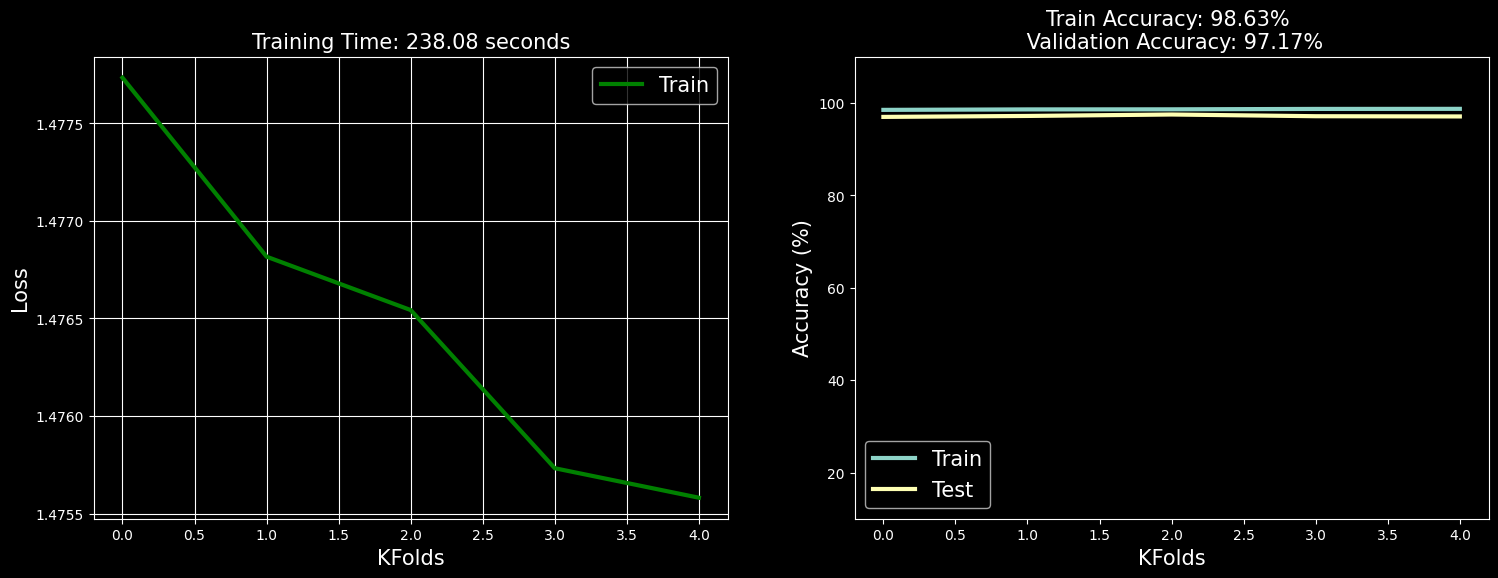

In [ ]:
#Visualize
fig,ax = plt.subplots(1, 2,figsize=(18,6))

ax[0].plot(results['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('KFolds', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title(f'Training Time: {results["trainTime"].sum():.2f} seconds', fontsize = 15)
ax[0].grid(True)

ax[1].plot(results['trainAcc'], label ='Train', lw = 3)
ax[1].plot(results['valAcc'], label ='Test', lw = 3)
ax[1].set_xlabel('KFolds', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {results["trainAcc"].mean():.2f}% \n Validation Accuracy: {results["valAcc"].mean():.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

## Final Test

In [ ]:
print(f"Test Samples: {len(test_loader)}")

Test Samples: 10000


In [ ]:
testAcc = model_testing(model_nn, test_loader)
print(f'Testset Accuracy: {testAcc:.2f}%')
print(dash_lines)

Testset Accuracy: 89.77%
--------------------------------------------------------------------------------


## Save `NN`

In [ ]:
# Save the model
torch.save(model_nn.state_dict(), 'Kmnist_model_adam.pth')

# Extra --

In [ ]:
#NN Model Architecture - Japanise Symbols classification task
model_seq_nn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128, dtype=torch.float64),
    nn.ReLU(),
    nn.Linear(128, 64,  dtype=torch.float64),
    nn.ReLU(),
    nn.Linear(64, 10,  dtype=torch.float64),
    nn.Softmax(dim=1)
)

#display
model_seq_nn

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): Softmax(dim=1)
)

In [ ]:
#Optimizer tunable*
optimizer = optim.Adam(model_seq_nn.parameters(), lr=learning_rate)

In [ ]:
#Training loop
losses = torch.zeros(num_epochs)
trainAcc = []
valAcc = []
trainTime = []

for epoch in range(num_epochs):
  batchLoss=[]
  batchtrainAcc=[]
  batchvalAcc=[]

  #training
  start_time = time.time()
  model.train()
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #forwardpass
    ypred = model(images)
    #loss
    loss = lossfunc(ypred, labels)

    #backpass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #storing results
    batchLoss.append(loss.item())
    ypred = ypred.cpu()
    labels = labels.cpu()

    # Compute batch accuracy
    acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == labels).float())
    batchtrainAcc.append(acc)

  end_time = time.time()
  trainTime.append(end_time - start_time)
  # End of batch loop
  # Compute average training accuracy and loss for this epoch
  trainAcc.append(np.mean(batchtrainAcc))
  losses[epoch] = np.mean(batchLoss)

  #evaluate on validation set
  model.eval()
  for batch_idx, (X, y) in enumerate(val_loader):
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      ypred = model(X)
      ypred = ypred.cpu()
      y = y.cpu()

      # Compute test accuracy
      batchvalAcc.append(100 * torch.mean((torch.argmax(ypred, dim=1) == y).float()))

  valAcc.append(np.mean(batchvalAcc))

  # Print epoch statistics
  print(f'Epoch: {epoch+1:>3}/{num_epochs}, Loss: {loss.item():>6.2f}, Train Accuracy: {trainAcc[-1]:>6.2f}, Validation Accuracy: {valAcc[-1]:>6.2f}')

print(f'Training Time: {np.sum(trainTime):.2f} seconds')

Epoch:   1/21, Loss:   1.49, Train Accuracy:  94.64, Validation Accuracy:  94.80
Epoch:   2/21, Loss:   1.49, Train Accuracy:  94.78, Validation Accuracy:  94.85
Epoch:   3/21, Loss:   1.52, Train Accuracy:  94.65, Validation Accuracy:  95.08
Epoch:   4/21, Loss:   1.52, Train Accuracy:  94.67, Validation Accuracy:  94.84
Epoch:   5/21, Loss:   1.49, Train Accuracy:  94.76, Validation Accuracy:  94.61
Epoch:   6/21, Loss:   1.46, Train Accuracy:  94.82, Validation Accuracy:  94.93
Epoch:   7/21, Loss:   1.46, Train Accuracy:  94.86, Validation Accuracy:  95.07
Epoch:   8/21, Loss:   1.46, Train Accuracy:  94.90, Validation Accuracy:  94.99
Epoch:   9/21, Loss:   1.49, Train Accuracy:  94.94, Validation Accuracy:  95.15
Epoch:  10/21, Loss:   1.55, Train Accuracy:  94.96, Validation Accuracy:  94.94
Epoch:  11/21, Loss:   1.49, Train Accuracy:  95.03, Validation Accuracy:  95.35
Epoch:  12/21, Loss:   1.52, Train Accuracy:  95.04, Validation Accuracy:  95.23
Epoch:  13/21, Loss:   1.49,

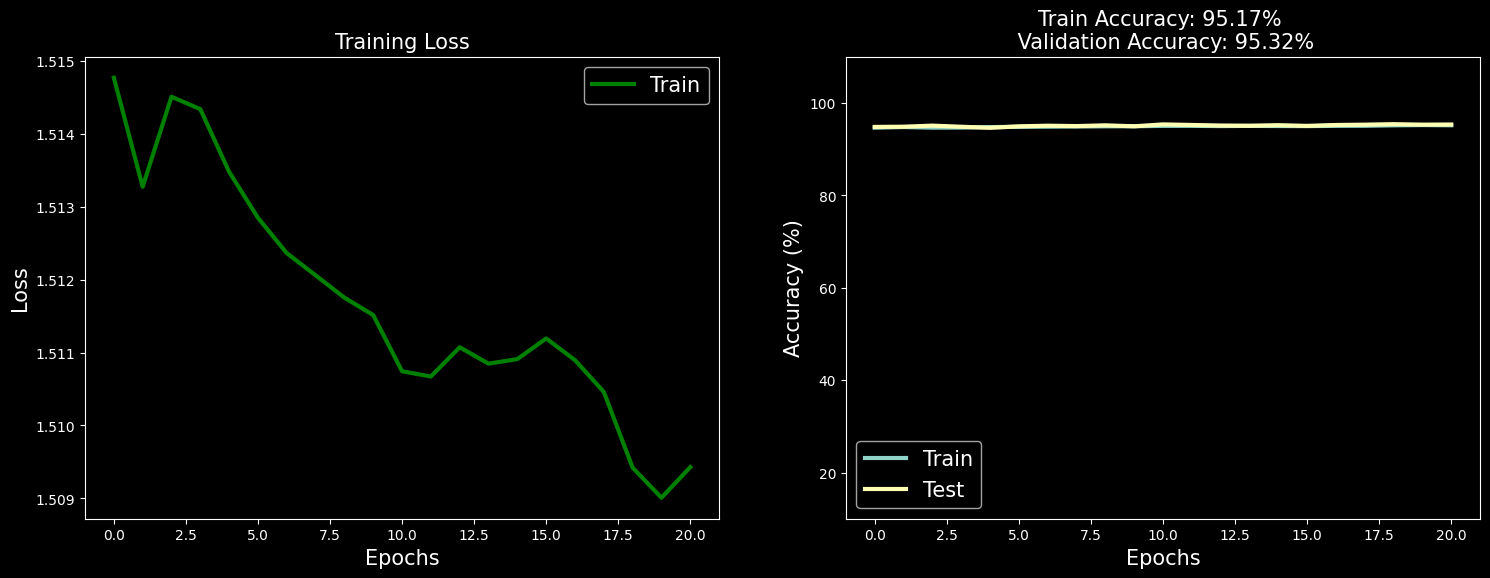

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(valAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Validation Accuracy: {valAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()